# Classification

### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier

from bayes_opt import BayesianOptimization
from tqdm import tqdm
from xgboost import XGBClassifier

# initialize PorterStemmer
p_stemmer = PorterStemmer()

# Set seed for RNG
SEED = 12

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Loading Dataset

In [2]:
df = pd.read_csv('reddit_combined_clean_label_split.csv') 
df['index'] = list(df.index)
df.head()

,dataset,category,subreddit,author,created_date,score,text,text_clean,label_1,label_2,label_3,final_label,index
0,train,comment,r/cscareerquestions,Linooney,4/30/2020 1:58,20,> People wait for existing faculty to die to h...,people wait for existing faculty to die to hav...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,0
1,train,comment,r/cscareerquestions,Dunan,4/30/2020 4:07,1,"> People who are being layed off, are they sof...",people who are being layed off are they softwa...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,1
2,train,comment,r/cscareerquestions,wtfnowdoIdo,1/2/2021 0:08,0,"> Personally, I switched jobs after 1.5 years ...",personally i switched jobs after years of expe...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,2
3,train,comment,r/cscareerquestions,nyamuk91,4/28/2020 16:31,6,"> PM's don't do performance reviews, that's fo...",pms dont do performance reviews thats for mana...,NEUTRAL,POSITIVE,NEUTRAL,POSITIVE,3
4,train,comment,r/cscareerquestions,OldSWEThrowaway,7/10/2021 2:19,-1,> pretty hard\nMore like impossible due to leg...,pretty hard more like impossible due to legal ...,POSITIVE,NEGATIVE,NEGATIVE,NEGATIVE,4


Inter-annotator agreement for dataset.

In [3]:
no_disagreements = len(df[((df['label_1'] != df['label_2']) & 
                        (df['label_2'] != df['label_3']) &
                        (df['label_3'] != df['label_1'])
                       )])

print("Inter-annotator agreement is {}%.".format((len(df) - no_disagreements)/len(df)*100))

Inter-annotator agreement is 90.54382722054675%.


General function to display sentiment and sentence length distribution.

In [4]:
def show_distribution(label, text, name=""):
    plt.figure(figsize=(18,6))

    # Bar graph visualisation of sentiment distribution
    plt.subplot(1,2,1)
    sns.countplot(x=label)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiments Distribution in " + name + " Dataset")

    # Bar graph visualisation of sentence length distribution
    plt.subplot(1,2,2)
    sns.histplot([len(s) for s in text])
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title("Sentence Length Distribution in " + name + " Dataset")

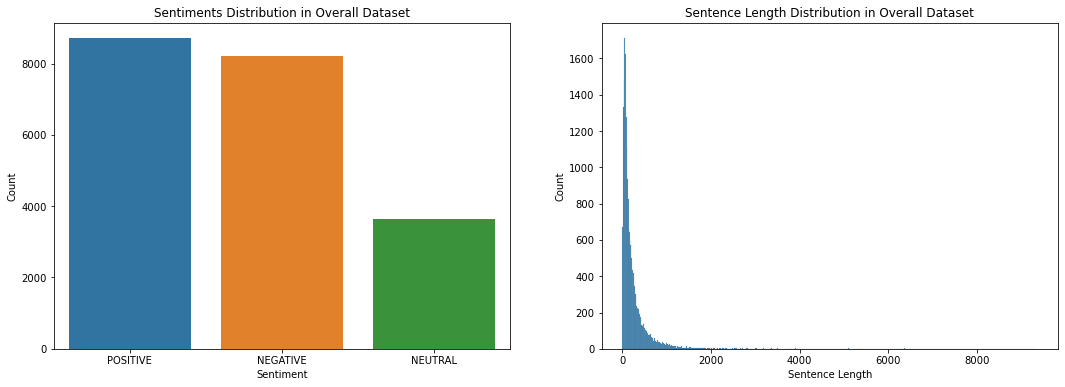

In [5]:
show_distribution(df['final_label'], df['text_clean'], "Overall")

### Text Normalization

In [6]:
# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Removal of Stopwords
def remove_stopword(text):
    nltk_tokenList = tokenize(text)

    filtered_sentence = []
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    
    return ' '.join(filtered_sentence)

# Stemming
def stemming(token_list):
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(p_stemmer.stem(word))

    return stemmed_list

# Lemmatization
def lemmatization(stemmed_list):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word in stemmed_list:
        lemma_list.append(wordnet_lemmatizer.lemmatize(word))

    return lemma_list

# Combination of stemming and lemmatization
def nltk_process(text):
    nltk_tokenList = tokenize(text)
    nltk_stemmedList = stemming(nltk_tokenList)
    nltk_lemmaList = lemmatization(nltk_stemmedList)

    return ' '.join(nltk_tokenList)

In [7]:
def normalize_df(df):    
    df['no_stopword_text_clean'] = df['text_clean'].apply(remove_stopword)
    df['normalize_text_clean'] = df['no_stopword_text_clean'].apply(nltk_process)

    # New dataframe of text normalized tweets
    columns_titles = ['dataset', 'normalize_text_clean', 'final_label', 'index']
    return df.reindex(columns=columns_titles)

norm_df = normalize_df(df)

### Split into train and test datasets

In [8]:
X_train = norm_df[norm_df['dataset'] == 'train']['normalize_text_clean']
X_test = norm_df[norm_df['dataset'] == 'test']['normalize_text_clean']

X_train.drop(columns=['dataset'], inplace=True)
X_test.drop(columns=['dataset'], inplace=True)

y_train = norm_df[norm_df['dataset'] == 'train'][['final_label', 'index']]
y_test = norm_df[norm_df['dataset'] == 'test'][['final_label', 'index']]

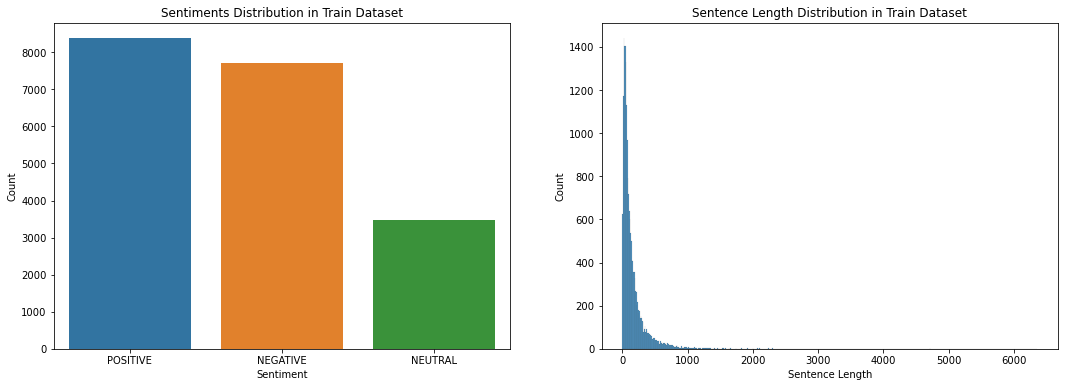

In [9]:
show_distribution(y_train['final_label'], X_train, "Train")

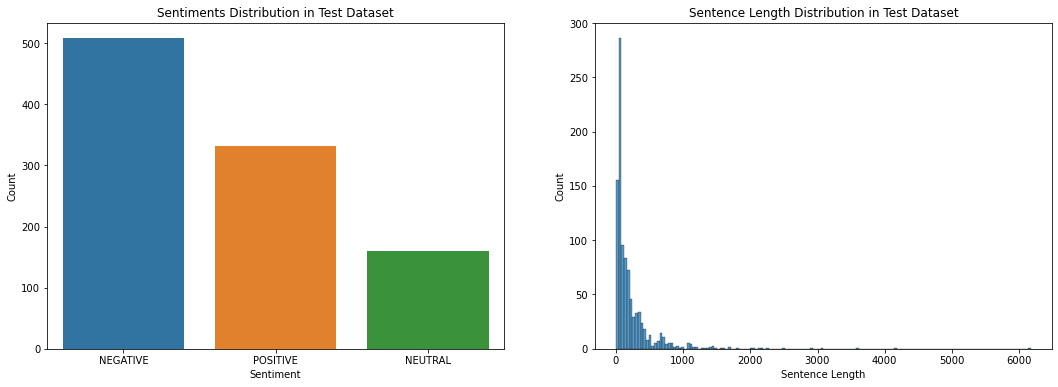

In [10]:
show_distribution(y_test['final_label'], X_test, "Test")

### Model Helpers

#### Logs

Storing results for comparision.

In [11]:
logs = {'models': {}, 'metrics': {}}
logs['models']['X_test'] = list(X_test)
logs['models']['y_test'] = list(y_test['final_label'])
logs['models']['index'] = list(y_test['index'])

# Remove index since we already stored
y_train = y_train['final_label']
y_test = y_test['final_label']

#### Vectorizers

TF-IDF Vectorizer

In [12]:
tfidf_vec = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  
tfidf_vec.fit(X_train)

TfidfVectorizer(max_df=0.7, max_features=2000, min_df=5)

In [13]:
X_train_dtm = tfidf_vec.transform(X_train)
X_test_dtm = tfidf_vec.transform(X_test)

#### Plots

General function for plotting accuracy and F1 metrics

In [14]:
def plot_metrics(rng, accuracy, f1s, cmp): 
    start, end, step = rng[0], rng[1], 1
    if len(rng) == 3:
        step = rng[2]

    plt.figure(figsize=(12, 6))

    # Plot accuracy dashed line
    plt.plot(range(start, end, step), accuracy, color='green', 
            linestyle='dashed', marker='o',
            markerfacecolor='green', markersize=10)
    # Plot f1 values dashed line
    plt.plot(range(start, end, step), f1s, color='blue', 
            linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
            
    plt.title('Accuracy & F1 Score vs ' + cmp)
    plt.xlabel(cmp)
    plt.legend(['Accuracy', 'F1 Score'], loc='upper right')

General function for showing evaluation metrics.

In [15]:
def show_metrics(y_test, y_pred):

    # Adding classes names for interpretation
    classes_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      columns=classes_names, index=classes_names)
                      
    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt='d');

    # Print classification report
    print(classification_report(y_test, y_pred))

### Traditional Machine Learning

#### Naive Bayes Classifier

In [16]:
model = MultinomialNB()
model.fit(X_train_dtm, y_train)

# Hyperparameter tuning with GridSearch
param = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1]}
clf = GridSearchCV(model, param, cv=10, return_train_score=True)
clf.fit(X_train_dtm, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.1, 1]},
             return_train_score=True)

In [17]:
print("Best hyperparameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Best hyperparameters:  {'alpha': 1}
Best score:  0.6034886165722624


In [18]:
%%time
y_pred = clf.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 63.0%
F1 Score: 58.201790749382134%
Wall time: 11.3 ms


              precision    recall  f1-score   support

    NEGATIVE       0.69      0.76      0.73       508
     NEUTRAL       0.60      0.02      0.04       160
    POSITIVE       0.55      0.73      0.63       332

    accuracy                           0.63      1000
   macro avg       0.61      0.50      0.46      1000
weighted avg       0.63      0.63      0.58      1000



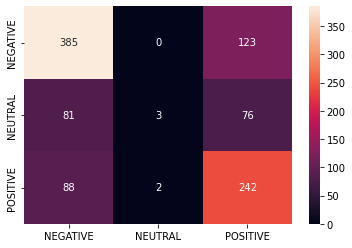

In [19]:
show_metrics(y_test, y_pred)

In [20]:
# Store results
logs['models']['nb'] = list(y_pred)
logs['metrics']['nb'] = {'accuracy': acc, 'f1 score': f1}

#### Support Vector Machine (SVM)

In [21]:
# Hyperparameter tuning with GridSearch
param = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']}
clf = GridSearchCV(SVC(), param, refit=True, verbose=2)
clf.fit(X_train_dtm, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  43.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  42.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  46.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  48.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  44.6s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  42.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  41.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  43.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  42.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  43.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  37.1s
[CV] END ....................C=0.1, gamma=0.1, 

[CV] END ..........................C=1, gamma=10, kernel=rbf; total time= 1.9min
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time= 2.0min
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time= 1.9min
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time= 2.0min
[CV] END ......................C=1, gamma=10, kernel=sigmoid; total time=  27.2s
[CV] END ......................C=1, gamma=10, kernel=sigmoid; total time=  25.6s
[CV] END ......................C=1, gamma=10, kernel=sigmoid; total time=  25.5s
[CV] END ......................C=1, gamma=10, kernel=sigmoid; total time=  24.0s
[CV] END ......................C=1, gamma=10, kernel=sigmoid; total time=  28.7s
[CV] END .......................C=1, gamma=10, kernel=linear; total time=  33.2s
[CV] END .......................C=1, gamma=10, kernel=linear; total time=  30.1s
[CV] END .......................C=1, gamma=10, kernel=linear; total time=  31.1s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             verbose=2)

In [22]:
print("Best hyperparameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Best hyperparameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.6618269926101149


In [23]:
%%time
y_pred = clf.predict(X_test_dtm)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 67.10000000000001%
F1 Score: 64.6009710868085%
Wall time: 2.37 s


              precision    recall  f1-score   support

    NEGATIVE       0.70      0.80      0.75       508
     NEUTRAL       0.56      0.17      0.27       160
    POSITIVE       0.64      0.72      0.68       332

    accuracy                           0.67      1000
   macro avg       0.63      0.56      0.56      1000
weighted avg       0.66      0.67      0.65      1000



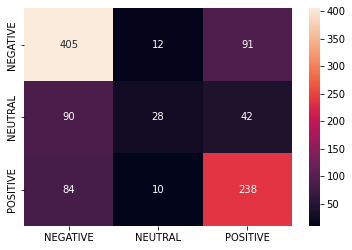

In [24]:
show_metrics(y_test, y_pred)

In [25]:
# Store results
logs['models']['svm'] = list(y_pred)
logs['metrics']['svm'] = {'accuracy': acc, 'f1 score': f1}

#### XGBoost

In [26]:
xgb_accuracy = []
xgb_f1s = []

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for i in tqdm(range(1, 31)):
    xgb = XGBClassifier(max_depth = i, n_estimators = 250)
    xgb.fit(X_train_dtm, y_train_encoded)
    y_pred_encoded = xgb.predict(X_test_dtm)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    xgb_accuracy.append(accuracy_score(y_test, y_pred))
    xgb_f1s.append(f1_score(y_test, y_pred, average='weighted'))

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:05:37<00:00, 131.26s/it]


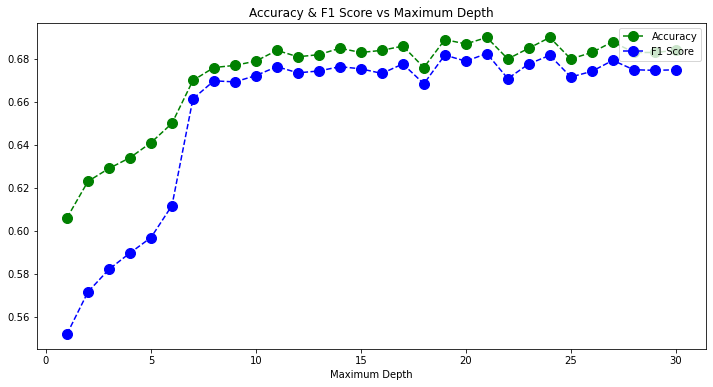

In [27]:
plot_metrics((1, 31), # tuple
             xgb_accuracy,  # list
             xgb_f1s, # list
             'Maximum Depth') # string eg. K Value, Maximum Depth

In [28]:
optimal_xgb_depth = xgb_f1s.index(max(xgb_f1s)) + 1
print("Optimal maximum depth: ", optimal_xgb_depth)
print("Highest f1 score achieved: ", max(xgb_f1s))

Optimal maximum depth:  21
Highest f1 score achieved:  0.6825290946357597


In [29]:
%%time
optimal_xgb = XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)
optimal_xgb.fit(X_train_dtm, y_train_encoded)
y_pred_encoded = optimal_xgb.predict(X_test_dtm)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 69.0%
F1 Score: 68.25290946357597%
Wall time: 2min 57s


              precision    recall  f1-score   support

    NEGATIVE       0.74      0.76      0.75       508
     NEUTRAL       0.55      0.36      0.44       160
    POSITIVE       0.66      0.73      0.69       332

    accuracy                           0.69      1000
   macro avg       0.65      0.62      0.63      1000
weighted avg       0.68      0.69      0.68      1000



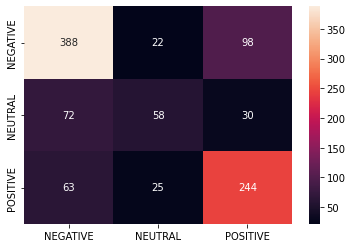

In [30]:
show_metrics(y_test, y_pred)

In [31]:
# Store results
logs['models']['xgboost'] = list(y_pred)
logs['metrics']['xgboost'] = {'accuracy': acc, 'f1 score': f1}

### Ensemble Classification

#### Stacked Classifier

In [32]:
stacked_est = [('xgb', XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250)),
               ('svm', SVC(C = 1, gamma = 1, kernel = 'rbf')),
               ('nb', MultinomialNB(alpha = 0.1))]
final_est = LogisticRegression(solver = 'saga', multi_class = 'multinomial')

In [33]:
%%time
stacked_clf = StackingClassifier(estimators = stacked_est,
                                 final_estimator = final_est,
                                 n_jobs = 1)
stacked_clf.fit(X_train_dtm, y_train_encoded)
y_pred_encoded = stacked_clf.predict(X_test_dtm)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

Accuracy Score: 68.2%
F1 Score: 66.71134687469336%
Wall time: 21min 21s


              precision    recall  f1-score   support

    NEGATIVE       0.71      0.79      0.75       508
     NEUTRAL       0.57      0.28      0.37       160
    POSITIVE       0.66      0.71      0.69       332

    accuracy                           0.68      1000
   macro avg       0.65      0.59      0.60      1000
weighted avg       0.67      0.68      0.67      1000



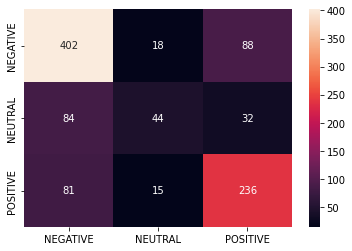

In [34]:
show_metrics(y_test, y_pred)

In [35]:
# Store results
logs['models']['stacked'] = list(y_pred)
logs['metrics']['stacked'] = {'accuracy': acc, 'f1 score': f1}

### Experiment Findings

In [36]:
# Sort base on f1 score
metrics_df = pd.DataFrame.from_dict(logs['metrics'])
metrics_df.sort_values(by=['f1 score'], axis=1, ascending=False, inplace=False)

,xgboost,stacked,svm,nb
accuracy,69.000000,68.200000,67.100000,63.000000
f1 score,68.252909,66.711347,64.600971,58.201791


In [37]:
# View test dataset with model results
findings_df = pd.DataFrame.from_dict(logs['models'])
findings_df = pd.merge(df, findings_df, left_on='index', right_on='index')
findings_df.head()

,dataset,category,subreddit,author,created_date,score,text,text_clean,label_1,label_2,...,final_label,index,no_stopword_text_clean,normalize_text_clean,X_test,y_test,nb,svm,xgboost,stacked
0,test,comment,r/china,SuspiciousStable9649,5/14/2022 3:53,1,"- Workers ?????????can see the ceiling, due ...",workers can see the ceiling due to market matu...,NEGATIVE,POSITIVE,...,NEGATIVE,19558,workers see ceiling due market maturations hu ...,workers see ceiling due market maturations hu ...,workers see ceiling due market maturations hu ...,NEGATIVE,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
1,test,comment,r/unitedkingdom,Phallic_Entity,11/1/2020 1:21,8,> The country will be broke and in masses of ...,the country will be broke and in masses of deb...,NEGATIVE,NEGATIVE,...,NEGATIVE,19559,country broke masses debt sell northern labour...,country broke masses debt sell northern labour...,country broke masses debt sell northern labour...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
2,test,comment,r/usa,dannylenwinn,4/2/2021 16:28,-1,"The U.S. economy added a whopping 916,000 job...",the us economy added a whopping jobs last mont...,NEGATIVE,POSITIVE,...,POSITIVE,19560,us economy added whopping jobs last month unem...,us economy added whopping jobs last month unem...,us economy added whopping jobs last month unem...,POSITIVE,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
3,test,comment,r/cscareerquestions,NaN,11/30/2022 21:11,26,?????????I don?????????t have cobol mentione...,i dont have cobol mentioned on my resume okay ...,POSITIVE,POSITIVE,...,POSITIVE,19561,dont cobol mentioned resume okay makes sense y...,dont cobol mentioned resume okay makes sense y...,dont cobol mentioned resume okay makes sense y...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE
4,test,comment,r/cscareerquestions,soprof,11/17/2016 9:41,13,20 years...\nThat's like a century in IT. Quak...,years thats like a century in it quake and dia...,POSITIVE,POSITIVE,...,POSITIVE,19562,years thats like century quake diablo released...,years thats like century quake diablo released...,years thats like century quake diablo released...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,POSITIVE


In [38]:
findings_df.to_csv('findings_TradML.csv')

In [39]:
metrics_df.to_csv('metrics_TradML.csv')